In [100]:
import uproot
file = uproot.open("ZH_HCC_ZLL_NanoV9_2017_867C.root")
tree = file["Events"]
branches = tree.arrays()

Masking Muons

In [101]:
muon_pt_mask = branches["Muon_pt"] > 25
muon_eta_mask = abs(branches["Muon_eta"]) < 2.4
muon_pt_eta_mask = muon_pt_mask & muon_eta_mask
muon_mask = [len(sublist) > 1 for sublist in branches["Muon_mass"][muon_pt_eta_mask]]

Masking Jets

In [102]:
jet_pt_mask = branches["Jet_pt"] > 25
jet_eta_mask = abs(branches["Jet_eta"]) < 2.4
jet_hadronflavour_mask = abs(branches["Jet_hadronFlavour"]) == 4
jet_pt_eta_mask = jet_pt_mask & jet_eta_mask & jet_hadronflavour_mask
jet_mask = [len(sublist) > 1 for sublist in branches["Jet_mass"][jet_pt_eta_mask]]

In [103]:
import numpy as np

combined_mask = np.logical_and(jet_mask, muon_mask)
print(combined_mask)

[False False False ... False False False]


Finding the 4-Vector of Muons

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from pylorentz import Momentum4

Muon1_mass = np.array([sublist[0] for sublist in branches["Muon_mass"][muon_pt_eta_mask][combined_mask]])
Muon1_eta = np.array([sublist[0] for sublist in branches["Muon_eta"][muon_pt_eta_mask][combined_mask]])
Muon1_phi = np.array([sublist[0] for sublist in branches["Muon_phi"][muon_pt_eta_mask][combined_mask]])
Muon1_pt = np.array([sublist[0] for sublist in branches["Muon_pt"][muon_pt_eta_mask][combined_mask]])

Muon2_mass = np.array([sublist[1] for sublist in branches["Muon_mass"][muon_pt_eta_mask][combined_mask]])
Muon2_eta = np.array([sublist[1] for sublist in branches["Muon_eta"][muon_pt_eta_mask][combined_mask]])
Muon2_phi = np.array([sublist[1] for sublist in branches["Muon_phi"][muon_pt_eta_mask][combined_mask]])
Muon2_pt = np.array([sublist[1] for sublist in branches["Muon_pt"][muon_pt_eta_mask][combined_mask]])

Muon1 = Momentum4.m_eta_phi_pt(Muon1_mass, Muon1_eta, Muon1_phi, Muon1_pt)
Muon2 = Momentum4.m_eta_phi_pt(Muon2_mass, Muon2_eta, Muon2_phi, Muon2_pt)

M_z = Muon1 + Muon2
# print(M_z.m)
# print(len(M_z.m))

Finding the 4-Vector of Jets

In [105]:
Jet1_mass = np.array([sublist[0] for sublist in branches["Jet_mass"][jet_pt_eta_mask][combined_mask]])
Jet1_eta = np.array([sublist[0] for sublist in branches["Jet_eta"][jet_pt_eta_mask][combined_mask]])
Jet1_phi = np.array([sublist[0] for sublist in branches["Jet_phi"][jet_pt_eta_mask][combined_mask]])
Jet1_pt = np.array([sublist[0] for sublist in branches["Jet_pt"][jet_pt_eta_mask][combined_mask]])

Jet2_mass = np.array([sublist[1] for sublist in branches["Jet_mass"][jet_pt_eta_mask][combined_mask]])
Jet2_eta = np.array([sublist[1] for sublist in branches["Jet_eta"][jet_pt_eta_mask][combined_mask]])
Jet2_phi = np.array([sublist[1] for sublist in branches["Jet_phi"][jet_pt_eta_mask][combined_mask]])
Jet2_pt = np.array([sublist[1] for sublist in branches["Jet_pt"][jet_pt_eta_mask][combined_mask]])

Jet1 = Momentum4.m_eta_phi_pt(Jet1_mass, Jet1_eta, Jet1_phi, Jet1_pt)
Jet2 = Momentum4.m_eta_phi_pt(Jet2_mass, Jet2_eta, Jet2_phi, Jet2_pt)

M_h = Jet1 + Jet2
print(M_h.m)
print(len(M_h.m))

[288.47455185  73.27688467 122.11110432 ...  82.12081985 108.25401798
 117.29644321]
1419


Finding Invariant Mass of Jets with Fitted Parameters

In [106]:
# generic imports
import sys
import argparse
import numpy as np
from tqdm.auto import tqdm
from array import array

# ROOT imports
import ROOT

# torch imports
import torch

# framework imports
from kinematic_fitter import KinematicFitter

def constraint_equations(params: torch.Tensor) -> torch.Tensor:
    # Constant parameters
    mass_z = torch.tensor(91.2).double()

    px1 = params[0]*torch.cos(params[4])
    px2 = params[1]*torch.cos(params[5])

    py1 = params[0]*torch.sin(params[4])
    py2 = params[1]*torch.sin(params[5])

    pz1 = params[0]*torch.sinh(params[8])
    pz2 = params[1]*torch.sinh(params[9])
                    
    # Calculate energy for muon 1
    E1 = torch.sqrt(px1**2 + py1**2 + pz1**2 + 0.106**2)
    # Calculate energy for muon 2
    E2 = torch.sqrt(px2**2 + py2**2 + pz2**2 + 0.106**2)
    # Calculate invariant mass
    invariant_mass_squared = (E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2
    invariant_mass = torch.sqrt(invariant_mass_squared)

    # Calculate constraint equations
    constraint1 = params[0]*torch.cos(params[4]) + params[1]*torch.cos(params[5]) + params[2]*torch.cos(params[6]) + params[3]*torch.cos(params[7])
    constraint2 = params[0]*torch.sin(params[4]) + params[1]*torch.sin(params[5]) + params[2]*torch.sin(params[6]) + params[3]*torch.sin(params[7])
    constraint3 = invariant_mass - mass_z

    # Combine constraint equations into a single tensor
    constraints = torch.stack([constraint1, constraint2, constraint3])

    return constraints

m_cc = []

# Maximum number of iterations for fitting
max_iterations = 10

for i in range(len((M_z).m)):
    parameters = torch.tensor([Muon1_pt[i], Muon2_pt[i], 
                               Jet1_pt[i], Jet2_pt[i], 
                               Muon1_phi[i], Muon2_phi[i],
                               Jet1_phi[i], Jet2_phi[i],
                               Muon1_eta[i], Muon2_eta[i],
                               Jet1_eta[i], Jet2_eta[i]], dtype=torch.float64)

    # Define the smearing values
    smear_values = [0.05*Muon1_pt[i], 0.05*Muon2_pt[i], 0.15*Jet1_pt[i], 0.15*Jet2_pt[i], 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

    # The covariance matrix initialization
    n_params = 12
    covariance_matrix = torch.zeros(n_params, n_params)
    for j in range(n_params):
        covariance_matrix[j, j] = smear_values[j]**2
    
    # Kinematic Fitter Initialization
    fitter = KinematicFitter(n_constraints=3, n_parameters=12, n_iterations=max_iterations)
    fitter.set_covariance_matrix(cov_matrix=covariance_matrix)
    ok = fitter.fit(measured_params=parameters, constraints=lambda parameters: constraint_equations(parameters))
    
    fitted_params = torch.tensor(fitter.get_fitted_measured_params(), dtype=torch.float64)
    
    fitted_Jet1 = Momentum4.m_eta_phi_pt(0, fitted_params[10], fitted_params[6], fitted_params[2])
    fitted_Jet2 = Momentum4.m_eta_phi_pt(0, fitted_params[11], fitted_params[7], fitted_params[3])
    
    M = fitted_Jet1 + fitted_Jet2
    m_cc.append(M.m)

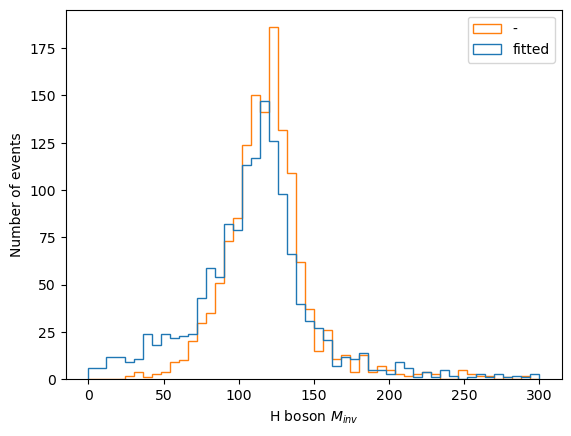

In [107]:
plt.hist([m_cc, (M_h).m], label = ["fitted", "-"], bins = 50, range = (0, 300), histtype="step")
plt.xlabel("H boson $M_{\t{inv}}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

Delta R

In [ ]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    return np.sqrt(delta_eta**2 + delta_phi**2)

Jet = []
for i in range(len((M_z).m)):
    if delta_r(Muon1_eta[i], Muon1_phi[i], Jet1_eta[i], Jet1_phi[i]) > 0.4:
        if delta_r(Muon1_eta[i], Muon1_phi[i], Jet2_eta[i], Jet2_phi[i]) > 0.4:
            if delta_r(Muon2_eta[i], Muon2_phi[i], Jet1_eta[i], Jet1_phi[i]) > 0.4:
                if delta_r(Muon2_eta[i], Muon2_phi[i], Jet2_eta[i], Jet2_phi[i]) > 0.4:
                    Jet1 = Momentum4.m_eta_phi_pt(0, Jet1_eta[i], Jet1_phi[i], Jet1_pt[i])
                    Jet2 = Momentum4.m_eta_phi_pt(0, Jet2_eta[i], Jet2_phi[i], Jet2_pt[i])
                    Jet.append((Jet1+Jet2).m)

Remnant Vectors

In [109]:
Jet3_pt = []
Jet3_phi = []
Jet3_eta = []
Jet4_pt = []
Jet4_phi = []
Jet4_eta = []

for sublist in branches["Jet_pt"][jet_pt_eta_mask][combined_mask]:
    if len(sublist) > 2:
        Jet3_pt.append(sublist[2])
    else:
        Jet3_pt.append(0)

for sublist in branches["Jet_phi"][jet_pt_eta_mask][combined_mask]:
    if len(sublist) > 2:
        Jet3_phi.append(sublist[2])
    else:
        Jet3_phi.append(0)

for sublist in branches["Jet_eta"][jet_pt_eta_mask][combined_mask]:
    if len(sublist) > 2:
        Jet3_eta.append(sublist[2])
    else:
        Jet3_eta.append(0)

for sublist in branches["Jet_pt"][jet_pt_eta_mask][combined_mask]:
    if len(sublist) > 3:
        Jet4_pt.append(sublist[3])
    else:
        Jet4_pt.append(0)

for sublist in branches["Jet_phi"][jet_pt_eta_mask][combined_mask]:
    if len(sublist) > 3:
        Jet4_phi.append(sublist[3])
    else:
        Jet4_phi.append(0)

for sublist in branches["Jet_eta"][jet_pt_eta_mask][combined_mask]:
    if len(sublist) > 3:
        Jet4_eta.append(sublist[3])
    else:
        Jet4_eta.append(0)

In [110]:
# generic imports
import sys
import argparse
import numpy as np
from tqdm.auto import tqdm
from array import array

# ROOT imports
import ROOT

# torch imports
import torch

# framework imports
from kinematic_fitter import KinematicFitter

def constraint_equations(params: torch.Tensor) -> torch.Tensor:
    # Constant parameters
    mass_z = torch.tensor(91.2).double()

    px1 = params[0]*torch.cos(params[4])
    px2 = params[1]*torch.cos(params[5])

    py1 = params[0]*torch.sin(params[4])
    py2 = params[1]*torch.sin(params[5])

    pz1 = params[0]*torch.sinh(params[8])
    pz2 = params[1]*torch.sinh(params[9])
                    
    # Calculate energy for muon 1
    E1 = torch.sqrt(px1**2 + py1**2 + pz1**2 + 0.106**2)
    # Calculate energy for muon 2
    E2 = torch.sqrt(px2**2 + py2**2 + pz2**2 + 0.106**2)
    # Calculate invariant mass
    invariant_mass_squared = (E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2
    invariant_mass = torch.sqrt(invariant_mass_squared)

    # Calculate constraint equations
    constraint1 = params[0]*torch.cos(params[4]) + params[1]*torch.cos(params[5]) + \
                    params[2]*torch.cos(params[6]) + params[3]*torch.cos(params[7]) + \
                    params[12]*torch.cos(params[14]) + params[13]*torch.cos(params[15])
    constraint2 = params[0]*torch.sin(params[4]) + params[1]*torch.sin(params[5]) + \
                    params[2]*torch.sin(params[6]) + params[3]*torch.sin(params[7]) + \
                    params[12]*torch.sin(params[14]) + params[13]*torch.sin(params[15])
    constraint3 = invariant_mass - mass_z

    # Combine constraint equations into a single tensor
    constraints = torch.stack([constraint1, constraint2, constraint3])
    
    return constraints

m_cc = []

# Maximum number of iterations for fitting
max_iterations = 10

for i in range(len(M_z.m)):
    if delta_r(Muon1_eta[i], Muon1_phi[i], Jet1_eta[i], Jet1_phi[i]) > 0.4:
        if delta_r(Muon1_eta[i], Muon1_phi[i], Jet2_eta[i], Jet2_phi[i]) > 0.4:
            if delta_r(Muon2_eta[i], Muon2_phi[i], Jet1_eta[i], Jet1_phi[i]) > 0.4:
                if delta_r(Muon2_eta[i], Muon2_phi[i], Jet2_eta[i], Jet2_phi[i]) > 0.4:
                    
                    parameters = torch.tensor([Muon1_pt[i], Muon2_pt[i], 
                                            Jet1_pt[i], Jet2_pt[i], 
                                            Muon1_phi[i], Muon2_phi[i],
                                            Jet1_phi[i], Jet2_phi[i],
                                            Muon1_eta[i], Muon2_eta[i],
                                            Jet1_eta[i], Jet2_eta[i],
                                            Jet3_pt[i], Jet4_pt[i],
                                            Jet3_phi[i], Jet4_phi[i]], dtype=torch.float64)

                    # Define the smearing values
                    smear_values = [0.05*Muon1_pt[i], 0.05*Muon2_pt[i], 0.15*Jet1_pt[i], 0.15*Jet2_pt[i],
                                     0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

                    # The covariance matrix initialization
                    n_params = 16
                    covariance_matrix = torch.zeros(n_params, n_params)
                    for j in range(n_params):
                        covariance_matrix[j, j] = smear_values[j]**2
                    
                    # Kinematic Fitter Initialization
                    fitter = KinematicFitter(n_constraints=3, n_parameters=16, n_iterations=max_iterations)
                    fitter.set_covariance_matrix(cov_matrix=covariance_matrix)
                    ok = fitter.fit(measured_params=parameters, constraints=lambda parameters: constraint_equations(parameters))
                    
                    fitted_params = torch.tensor(fitter.get_fitted_measured_params(), dtype=torch.float64)
                    
                    fitted_Jet1 = Momentum4.m_eta_phi_pt(0, fitted_params[10], fitted_params[6], fitted_params[2])
                    fitted_Jet2 = Momentum4.m_eta_phi_pt(0, fitted_params[11], fitted_params[7], fitted_params[3])
                    
                    M = fitted_Jet1 + fitted_Jet2
                    m_cc.append(M.m)

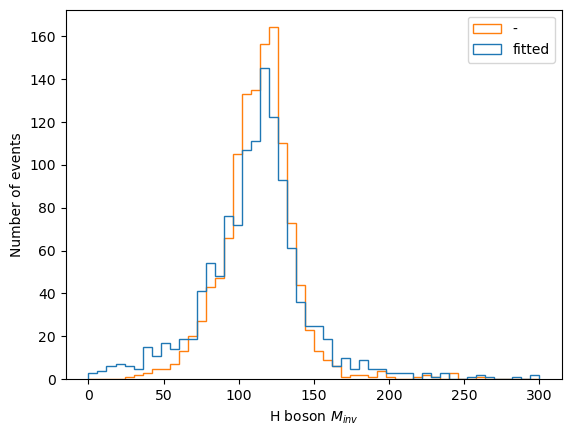

In [111]:
plt.hist([m_cc, Jet], label = ["fitted", "-"], bins = 50, range = (0, 300), histtype="step")
plt.xlabel("H boson $M_{\t{inv}}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()